#**유통 판매량 예측 및 재고 최적화**
## **단계2 : 모델링을 위한 데이터 전처리**

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/project5/'

### **(2) 라이브러리 설치 및 불러오기**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Input, Dense, LSTM, Conv1D, Flatten, SimpleRNN
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

In [ ]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

# **2.데이터셋 구성하기**

* 세부 요구사항
    * 상품코드 별로 각각 데이터셋을 구성해야 합니다.
    * 도출된 변수들을 포함하는 데이터셋을 구성합니다.


In [ ]:
def replace_under_iqr(total, cols):
    df = total.copy()
    for c in cols:
        tmp = df[c]

        Q3, Q1 = tmp.quantile(0.75), tmp.quantile(0.25)
        IQR = Q3 - Q1

        idx = np.argwhere((tmp < (Q1 - 1.5 * IQR))).reshape(-1, )
        tmp.loc[idx] = np.NaN

        df[c] = tmp

    return df

def make_datetime(data):
    data['weekday'] = data['Date'].dt.weekday
    data['month'] = data['Date'].dt.month
    data['week'] = data['Date'].dt.isocalendar().week

    return data

def decomp(df, period):
    decomp = sm.tsa.seasonal_decompose(df['Qty'], model = 'additive', period = period)

    # 시계열 분해 결과를 받아서 데이터프레임으로 저장
    result = pd.DataFrame({'trend':decomp.trend, 'seasonal':decomp.seasonal})
    return result

def merge_dataset(sales, products, stores, orders, oil_price, store_id, product_id):

    stores['State'] = stores['State'].str.replace('\t', '')

    new_oil_price = (oil_price.set_index('Date').asfreq('1D')
                    .interpolate(method='linear')
                    .bfill())

    sales_loc = sales.loc[(sales['Store_ID'] == store_id) & (sales['Product_ID'] == product_id)]
    products_loc = products.loc[products['Product_ID'] == product_id]
    stores_loc = stores.loc[stores['Store_ID'] == store_id]
    orders_loc = orders.loc[orders['Store_ID'] == store_id]

    total = pd.merge(sales_loc, products_loc,
                    how='left',
                    on=['Product_ID'])

    total = pd.merge(total, orders_loc,
                    how='left',
                    on=['Date', 'Store_ID'])

    total = pd.merge(total, stores_loc,
                    how='left',
                    on=['Store_ID'])

    total = pd.merge(new_oil_price, total,
                     how='left',
                     on=['Date'])

    df = total[['Date', 'WTI_Price', 'Qty', 'CustomerCount']]

    replaced_df = replace_under_iqr(df, ['WTI_Price', 'Qty', 'CustomerCount'])

    final_df = replaced_df.interpolate(method='linear').bfill()

    final_df = make_datetime(final_df)

    final_df = pd.get_dummies(final_df, columns=['weekday'],
                              drop_first=True,
                              dtype=int)

    final_df['Qty_5d'] = final_df['Qty'].shift(5)
    final_df['Qty_12d'] = final_df['Qty'].shift(12)

    final_df['Qty_7ma'] = final_df['Qty'].rolling(7).mean()
    final_df['Qty_28ma'] = final_df['Qty'].rolling(28).mean()

    final_df['WTI_Price_7ma'] = final_df['WTI_Price'].rolling(7).mean()
    final_df['WTI_Price_28ma'] = final_df['WTI_Price'].rolling(28).mean()

    final_df['CustomerCount_7ma'] = final_df['CustomerCount'].rolling(7).mean()
    final_df['CustomerCount_28ma'] = final_df['CustomerCount'].rolling(28).mean()

    final_df['Qty_ma_diff'] = final_df['Qty_7ma'] - final_df['Qty_28ma']
    final_df['WTI_Price_ma_diff'] = final_df['WTI_Price_7ma'] - final_df['WTI_Price_28ma']
    final_df['CustomerCount_ma_diff'] = final_df['CustomerCount_7ma'] - final_df['CustomerCount_28ma']

    decomp_qty = decomp(final_df, 7) # period 7
    real_final_df = pd.concat([final_df,decomp_qty], axis=1)

    real_final_df.drop(['Date'], axis=1, inplace=True)
    real_final_df.dropna(axis=0, inplace=True)

    real_final_df.reset_index(drop=True, inplace=True)

    return real_final_df

## **(1) 상품 : 3 - Beverage**

In [ ]:
beverage = merge_dataset(sales, products, stores, orders, oil_price, 44, 3)
beverage.head(10)

,WTI_Price,Qty,CustomerCount,month,week,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,...,Qty_28ma,WTI_Price_7ma,WTI_Price_28ma,CustomerCount_7ma,CustomerCount_28ma,Qty_ma_diff,WTI_Price_ma_diff,CustomerCount_ma_diff,trend,seasonal
0,97.49,5512.0,3491.0,1,5,1,0,0,0,0,...,9090.607143,96.575714,94.098750,4006.428571,4184.785714,-1055.607143,2.476964,-178.357143,8020.000000,-1729.439630
1,97.34,6482.0,3810.0,1,5,0,1,0,0,0,...,8970.214286,96.717143,94.177321,3985.857143,4162.928571,-1085.642857,2.539821,-177.071429,7342.428571,-1052.147818
2,98.25,5484.0,3638.0,1,5,0,0,1,0,0,...,8814.178571,96.862857,94.288393,3995.857143,4134.928571,-939.035714,2.574464,-139.071429,6583.285714,-2433.904351
3,97.55,7566.0,4189.0,1,5,0,0,0,1,0,...,8775.571429,96.990000,94.427321,4027.000000,4135.714286,-755.571429,2.562679,-108.714286,6198.285714,-1046.135187
4,97.18,7223.0,5130.0,2,5,0,0,0,0,1,...,8492.357143,97.104286,94.559464,4072.285714,4128.178571,-1149.928571,2.544821,-55.892857,5867.142857,3097.071142
5,96.81,6995.0,4827.0,2,5,0,0,0,0,0,...,8184.821429,97.205714,94.684821,4115.428571,4117.607143,-1601.535714,2.520893,-2.178571,5460.142857,4129.385718
6,96.44,4126.0,3989.0,2,6,0,0,0,0,0,...,8050.035714,97.294286,94.803393,4153.428571,4120.178571,-1851.750000,2.490893,33.250000,5206.571429,-964.829874
7,97.24,3194.0,3742.0,2,6,1,0,0,0,0,...,7907.392857,97.258571,94.943750,4189.285714,4123.000000,-2040.250000,2.314821,66.285714,4652.714286,-1729.439630
8,97.40,3633.0,4147.0,2,6,0,1,0,0,0,...,7722.857143,97.267143,95.140179,4237.428571,4119.178571,-2262.714286,2.126964,118.250000,4496.142857,-1052.147818
9,97.84,3709.0,3712.0,2,6,0,0,1,0,0,...,7619.392857,97.208571,95.371607,4248.000000,4118.785714,-2412.821429,1.836964,129.214286,4331.000000,-2433.904351


## **(2) 상품 : 12 - Milk**

In [ ]:
milk = merge_dataset(sales, products, stores, orders, oil_price, 44, 12)
beverage.head(10)

,WTI_Price,Qty,CustomerCount,month,week,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,...,Qty_28ma,WTI_Price_7ma,WTI_Price_28ma,CustomerCount_7ma,CustomerCount_28ma,Qty_ma_diff,WTI_Price_ma_diff,CustomerCount_ma_diff,trend,seasonal
0,97.49,5512.0,3491.0,1,5,1,0,0,0,0,...,9090.607143,96.575714,94.098750,4006.428571,4184.785714,-1055.607143,2.476964,-178.357143,8020.000000,-1729.439630
1,97.34,6482.0,3810.0,1,5,0,1,0,0,0,...,8970.214286,96.717143,94.177321,3985.857143,4162.928571,-1085.642857,2.539821,-177.071429,7342.428571,-1052.147818
2,98.25,5484.0,3638.0,1,5,0,0,1,0,0,...,8814.178571,96.862857,94.288393,3995.857143,4134.928571,-939.035714,2.574464,-139.071429,6583.285714,-2433.904351
3,97.55,7566.0,4189.0,1,5,0,0,0,1,0,...,8775.571429,96.990000,94.427321,4027.000000,4135.714286,-755.571429,2.562679,-108.714286,6198.285714,-1046.135187
4,97.18,7223.0,5130.0,2,5,0,0,0,0,1,...,8492.357143,97.104286,94.559464,4072.285714,4128.178571,-1149.928571,2.544821,-55.892857,5867.142857,3097.071142
5,96.81,6995.0,4827.0,2,5,0,0,0,0,0,...,8184.821429,97.205714,94.684821,4115.428571,4117.607143,-1601.535714,2.520893,-2.178571,5460.142857,4129.385718
6,96.44,4126.0,3989.0,2,6,0,0,0,0,0,...,8050.035714,97.294286,94.803393,4153.428571,4120.178571,-1851.750000,2.490893,33.250000,5206.571429,-964.829874
7,97.24,3194.0,3742.0,2,6,1,0,0,0,0,...,7907.392857,97.258571,94.943750,4189.285714,4123.000000,-2040.250000,2.314821,66.285714,4652.714286,-1729.439630
8,97.40,3633.0,4147.0,2,6,0,1,0,0,0,...,7722.857143,97.267143,95.140179,4237.428571,4119.178571,-2262.714286,2.126964,118.250000,4496.142857,-1052.147818
9,97.84,3709.0,3712.0,2,6,0,0,1,0,0,...,7619.392857,97.208571,95.371607,4248.000000,4118.785714,-2412.821429,1.836964,129.214286,4331.000000,-2433.904351


## **(3) 상품 : 42 - Agricultural products**

In [ ]:
agri = merge_dataset(sales, products, stores, orders, oil_price, 44, 42)
beverage.head(10)

,WTI_Price,Qty,CustomerCount,month,week,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,...,Qty_28ma,WTI_Price_7ma,WTI_Price_28ma,CustomerCount_7ma,CustomerCount_28ma,Qty_ma_diff,WTI_Price_ma_diff,CustomerCount_ma_diff,trend,seasonal
0,97.49,5512.0,3491.0,1,5,1,0,0,0,0,...,9090.607143,96.575714,94.098750,4006.428571,4184.785714,-1055.607143,2.476964,-178.357143,8020.000000,-1729.439630
1,97.34,6482.0,3810.0,1,5,0,1,0,0,0,...,8970.214286,96.717143,94.177321,3985.857143,4162.928571,-1085.642857,2.539821,-177.071429,7342.428571,-1052.147818
2,98.25,5484.0,3638.0,1,5,0,0,1,0,0,...,8814.178571,96.862857,94.288393,3995.857143,4134.928571,-939.035714,2.574464,-139.071429,6583.285714,-2433.904351
3,97.55,7566.0,4189.0,1,5,0,0,0,1,0,...,8775.571429,96.990000,94.427321,4027.000000,4135.714286,-755.571429,2.562679,-108.714286,6198.285714,-1046.135187
4,97.18,7223.0,5130.0,2,5,0,0,0,0,1,...,8492.357143,97.104286,94.559464,4072.285714,4128.178571,-1149.928571,2.544821,-55.892857,5867.142857,3097.071142
5,96.81,6995.0,4827.0,2,5,0,0,0,0,0,...,8184.821429,97.205714,94.684821,4115.428571,4117.607143,-1601.535714,2.520893,-2.178571,5460.142857,4129.385718
6,96.44,4126.0,3989.0,2,6,0,0,0,0,0,...,8050.035714,97.294286,94.803393,4153.428571,4120.178571,-1851.750000,2.490893,33.250000,5206.571429,-964.829874
7,97.24,3194.0,3742.0,2,6,1,0,0,0,0,...,7907.392857,97.258571,94.943750,4189.285714,4123.000000,-2040.250000,2.314821,66.285714,4652.714286,-1729.439630
8,97.40,3633.0,4147.0,2,6,0,1,0,0,0,...,7722.857143,97.267143,95.140179,4237.428571,4119.178571,-2262.714286,2.126964,118.250000,4496.142857,-1052.147818
9,97.84,3709.0,3712.0,2,6,0,0,1,0,0,...,7619.392857,97.208571,95.371607,4248.000000,4118.785714,-2412.821429,1.836964,129.214286,4331.000000,-2433.904351


# **3.Baseline Model**

* **세부 요구사항**
    * 데이터 준비
        * 스케일링
            * 교과서 적으로는 데이터 분할 이후 스케일링하는게 맞지만, 데이터 건수가 충분히 크다면, 스케일링을 먼저 하기도 합니다.
            * 여기서는 먼저 스케일링을 한 후 데이터 분할을 합니다.
        * 데이터 분할
            * 검증셋 구성 : 학습용 데이터에서 최근 60일을 검증셋으로 사용.

    * 모델링
        * Dense Layer 1개(output layer)만으로 모델을 생성합니다.
        * 모델의 검증 성능을 평가하고 기록합니다.
        * 평가 지표 : RMSE, MAE, MAPE, R2 Score


## **(1) 상품 : 3 - Beverage**

### **1) 데이터 준비**

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
df = beverage

df['target'] = df['Qty'].shift(-2)
dataset = df.dropna(axis=0)

train, valid = dataset[:-60], dataset[-60:]

x_train, x_val, y_train, y_val = train.drop(['target'], axis=1), valid.drop(['target'], axis=1), train['target'], valid['target']
print(x_train.shape, y_train.shape)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.fit_transform(x_val)

(1063, 24) (1063,)


### **2) 모델링**

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 86782928.0000 - val_loss: 143743008.0000
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 90626744.0000 - val_loss: 143741536.0000
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 87326552.0000 - val_loss: 143740048.0000
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 88851688.0000 - val_loss: 143738560.0000
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 85434840.0000 - val_loss: 143737024.0000
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 85125944.0000 - val_loss: 143735472.0000
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 86357016.0000 - val_loss: 143733952.0000
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 84973120.0000 - val_loss: 143732464.0000
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 89879088.0000 - val_loss: 143730864.0000
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 86388824.0000 - val_loss: 143729360.000

2024/11/15 02:10:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: Reading databricks credential configuration failed with MLflow tracking URI 'databricks', Please ensure that you installed 'databricks-sdk' library, set correct tracking URI and set up databricks authentication configuration correctly. The available tracking URI can be either 'databricks' (using 'DEFAULT' authentication profile) or 'databricks://{profile}'. To set up databricks authentication configuration, you can set environmental variables DATABRICKS_HOST + DATABRICKS_TOKEN, or set environmental variables DATABRICKS_HOST + DATABRICKS_CLIENT_ID + DATABRICKS_CLIENT_SECRET, or you can edit '~/.databrickscfg' file to set host + token or host + client_id + client_secret for specific profile section, or you can log in by command 'databricks auth login' which configures an authentication profile in '~/.databrickscfg' with auth_type of 'databricks-cli'.
For details of these aut

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
RMSE: 11983.007403269457
MAE: 11387.12724240621
MAPE: 0.9999774947874532
R2 Score: -9.254122209781364


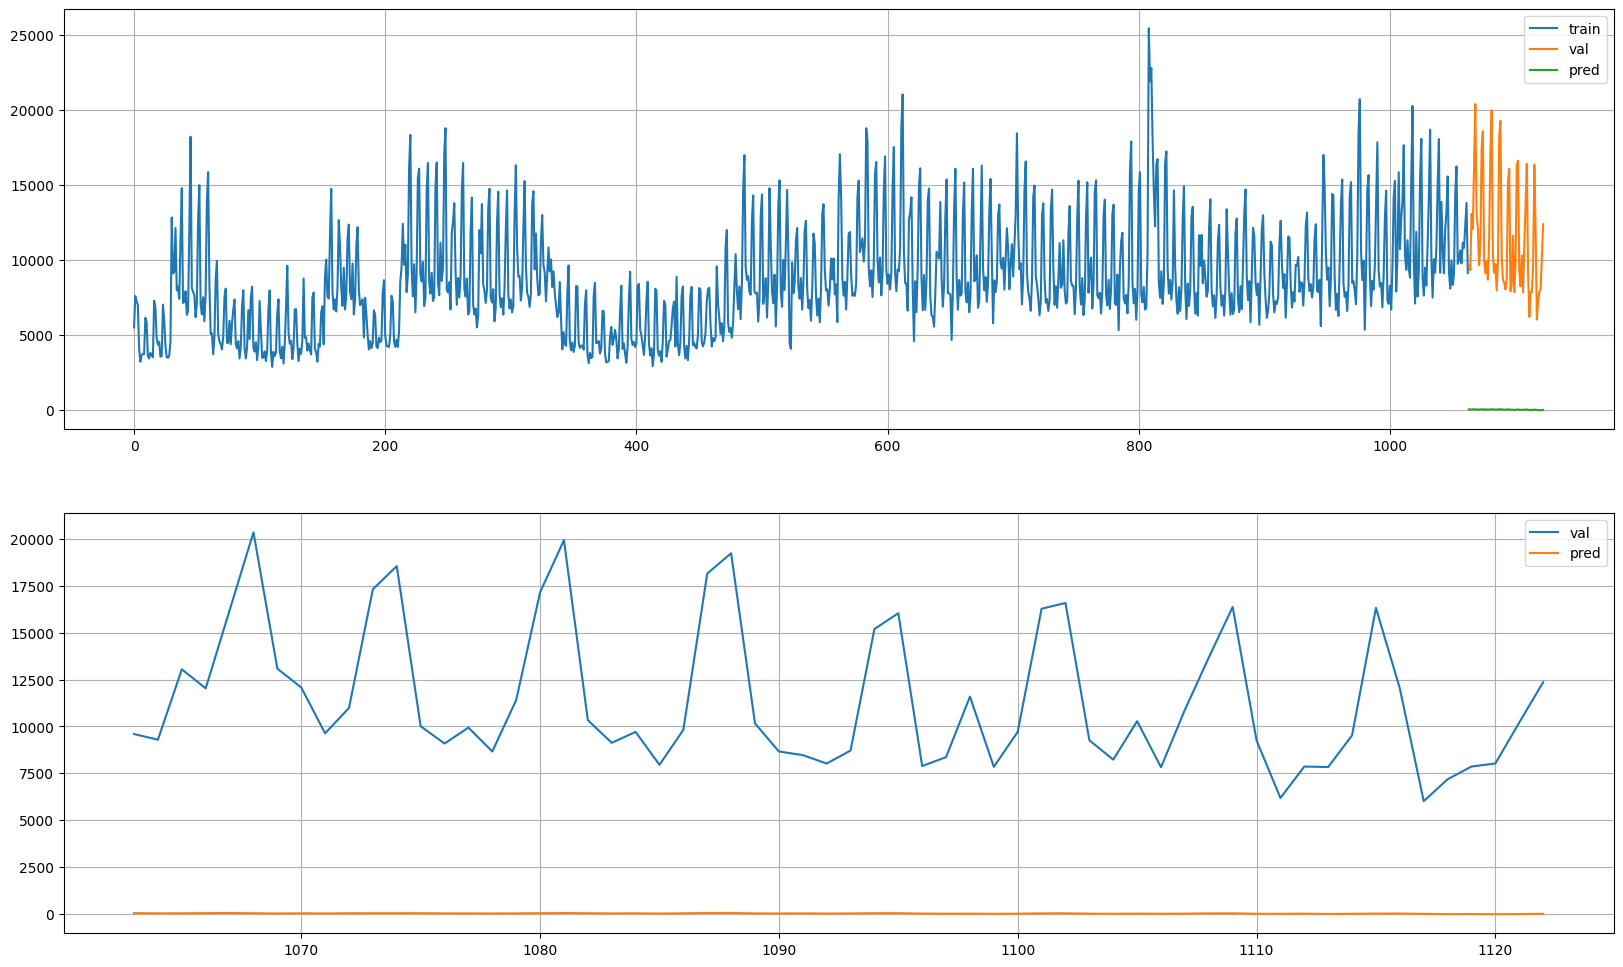

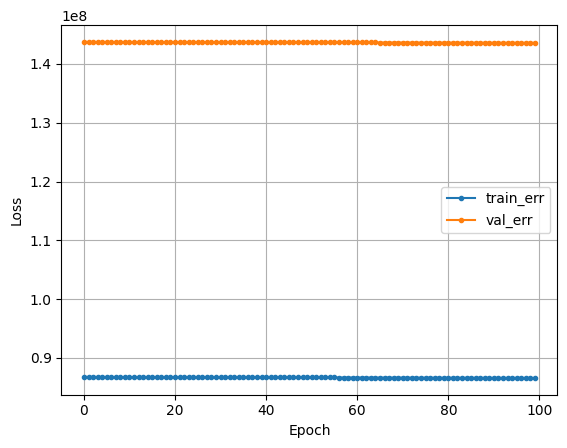

In [ ]:
df = beverage

df['target'] = df['Qty'].shift(-2)
dataset = df.dropna(axis=0)

train, valid = dataset[:-60], dataset[-60:]

x_train, x_val, y_train, y_val = train.drop(['target'], axis=1), valid.drop(['target'], axis=1), train['target'], valid['target']
print(x_train.shape, y_train.shape)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.fit_transform(x_val)

# 딥러닝 베이스라인 모델 생성
input_shape = x_train.shape[1:]

model = Sequential()
model.add(Input(shape=input_shape))
model.add(Dense(1)) # input_shape는 feature의 개수
model.compile(loss='mse', optimizer=Adam())

# 모델 학습
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val))

# 모델 평가
pred = model.predict(x_val)
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, pred))}")
print(f"MAE: {mean_absolute_error(y_val, pred)}")
print(f"MAPE: {mean_absolute_percentage_error(y_val, pred)}")
print(f"R2 Score: {r2_score(y_val, pred)}")

# 결과 시각화
plot_model_result(y_train, y_val, pred)
dl_history_plot(history.history)

### RNN

In [ ]:
# RNN 베이스라인 모델 생성
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

In [ ]:
df = beverage

df['target'] = df['Qty'].shift(-2)
dataset = df.dropna(axis=0)

x_ = dataset.drop(['target'], axis=1)
y_ = dataset['target'] / 10000

scaler = StandardScaler()
x_ = scaler.fit_transform(x_)

x, y = temporalize(pd.DataFrame(x_), y_, 7)

x_train, x_val, y_train, y_val = x[:-60], x[-60:], y[:-60], y[-60:]
print(x_train.shape, y_train.shape)

(1057, 7, 24) (1057,)


Epoch 1/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.3533 - val_loss: 0.0525
Epoch 2/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0501 - val_loss: 0.0741
Epoch 3/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0267 - val_loss: 0.0464
Epoch 4/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0213 - val_loss: 0.0291
Epoch 5/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0134 - val_loss: 0.0621
Epoch 6/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0503 - val_loss: 0.0408
Epoch 7/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0304 - val_loss: 0.0226
Epoch 8/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126 - val_loss: 0.0160
Epoch 9/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - val_loss: 0.0405
Epoch 10/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0229 - val_loss: 0.0259
Epoch 11/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 - val_loss: 0.0210
Epoch 12/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

2024/11/15 02:12:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: Reading databricks credential configuration failed with MLflow tracking URI 'databricks', Please ensure that you installed 'databricks-sdk' library, set correct tracking URI and set up databricks authentication configuration correctly. The available tracking URI can be either 'databricks' (using 'DEFAULT' authentication profile) or 'databricks://{profile}'. To set up databricks authentication configuration, you can set environmental variables DATABRICKS_HOST + DATABRICKS_TOKEN, or set environmental variables DATABRICKS_HOST + DATABRICKS_CLIENT_ID + DATABRICKS_CLIENT_SECRET, or you can edit '~/.databrickscfg' file to set host + token or host + client_id + client_secret for specific profile section, or you can log in by command 'databricks auth login' which configures an authentication profile in '~/.databrickscfg' with auth_type of 'databricks-cli'.
For details of these aut

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step
RMSE: 0.11079485850116383
MAE: 0.07885976021130879
MAPE: 0.06968165478832483
R2 Score: 0.9123390751675715


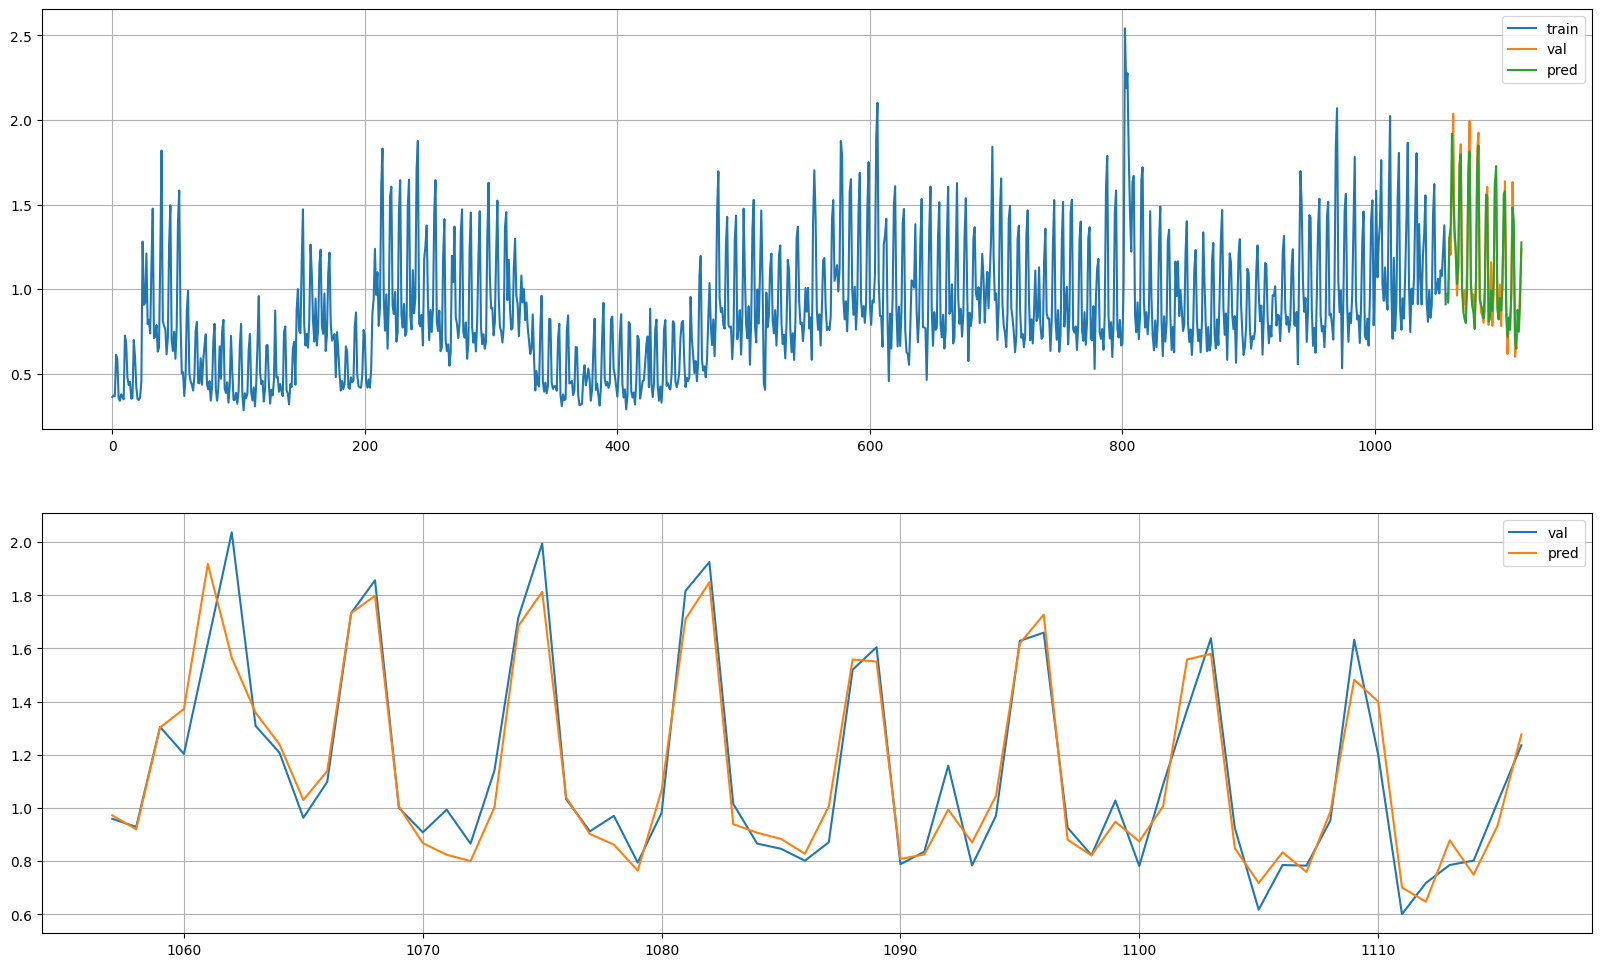

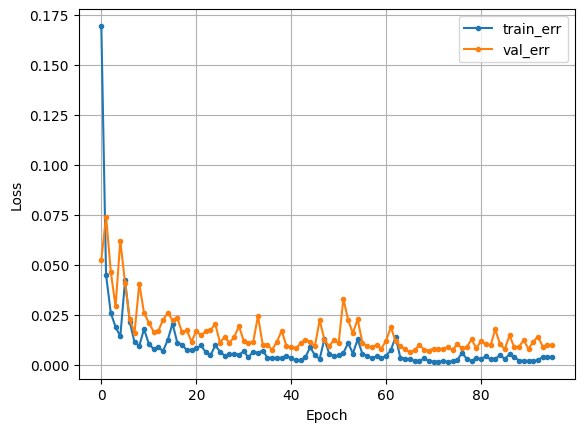

In [ ]:
df = beverage

df['target'] = df['Qty'].shift(-2)
dataset = df.dropna(axis=0)

x_ = dataset.drop(['target'], axis=1)
y_ = dataset['target'] / 10000

scaler = StandardScaler()
x_ = scaler.fit_transform(x_)

x, y = temporalize(pd.DataFrame(x_), y_, 7)

x_train, x_val, y_train, y_val = x[:-60], x[-60:], y[:-60], y[-60:]
print(x_train.shape, y_train.shape)

input_shape = x_train.shape[1:]

model = Sequential()
model.add(Input(shape=input_shape))
model.add(SimpleRNN(128, activation='tanh', return_sequences=True)) # 추가된 SimpleRNN 레이어
model.add(SimpleRNN(128, activation='tanh', return_sequences=False)) # 추가된 SimpleRNN 레이어
model.add(Dense(1)) # input_shape는 feature의 개수
model.compile(loss='huber', optimizer=Adam(0.003))

es = EarlyStopping(patience=30, restore_best_weights=True)
#lr =

# 모델 학습
history = model.fit(x_train, y_train, epochs=150, batch_size=32, validation_data=(x_val, y_val),
                    callbacks=[es])

# 모델 평가
pred = model.predict(x_val)
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, pred))}")
print(f"MAE: {mean_absolute_error(y_val, pred)}")
print(f"MAPE: {mean_absolute_percentage_error(y_val, pred)}")
print(f"R2 Score: {r2_score(y_val, pred)}")

# 결과 시각화
plot_model_result(y_train, y_val, pred)
dl_history_plot(history.history)

### LSTM

Epoch 1/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1980 - val_loss: 0.1105
Epoch 2/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0264 - val_loss: 0.0491
Epoch 3/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0199 - val_loss: 0.0409
Epoch 4/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0122 - val_loss: 0.0189
Epoch 5/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0136 - val_loss: 0.0212
Epoch 6/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0117 - val_loss: 0.0184
Epoch 7/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0099 - val_loss: 0.0389
Epoch 8/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0204 - val_loss: 0.0251
Epoch 9/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0097 - val_loss: 0.0152
Epoch 10/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0081 - val_loss: 0.0189
Epoch 11/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092 - val_loss: 0.0168
Epoch 12/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
RMSE: 0.1281646743637082
MAE: 0.08794285150845846
MAPE: 0.0753303246959816
R2 Score: 0.8826985148643303


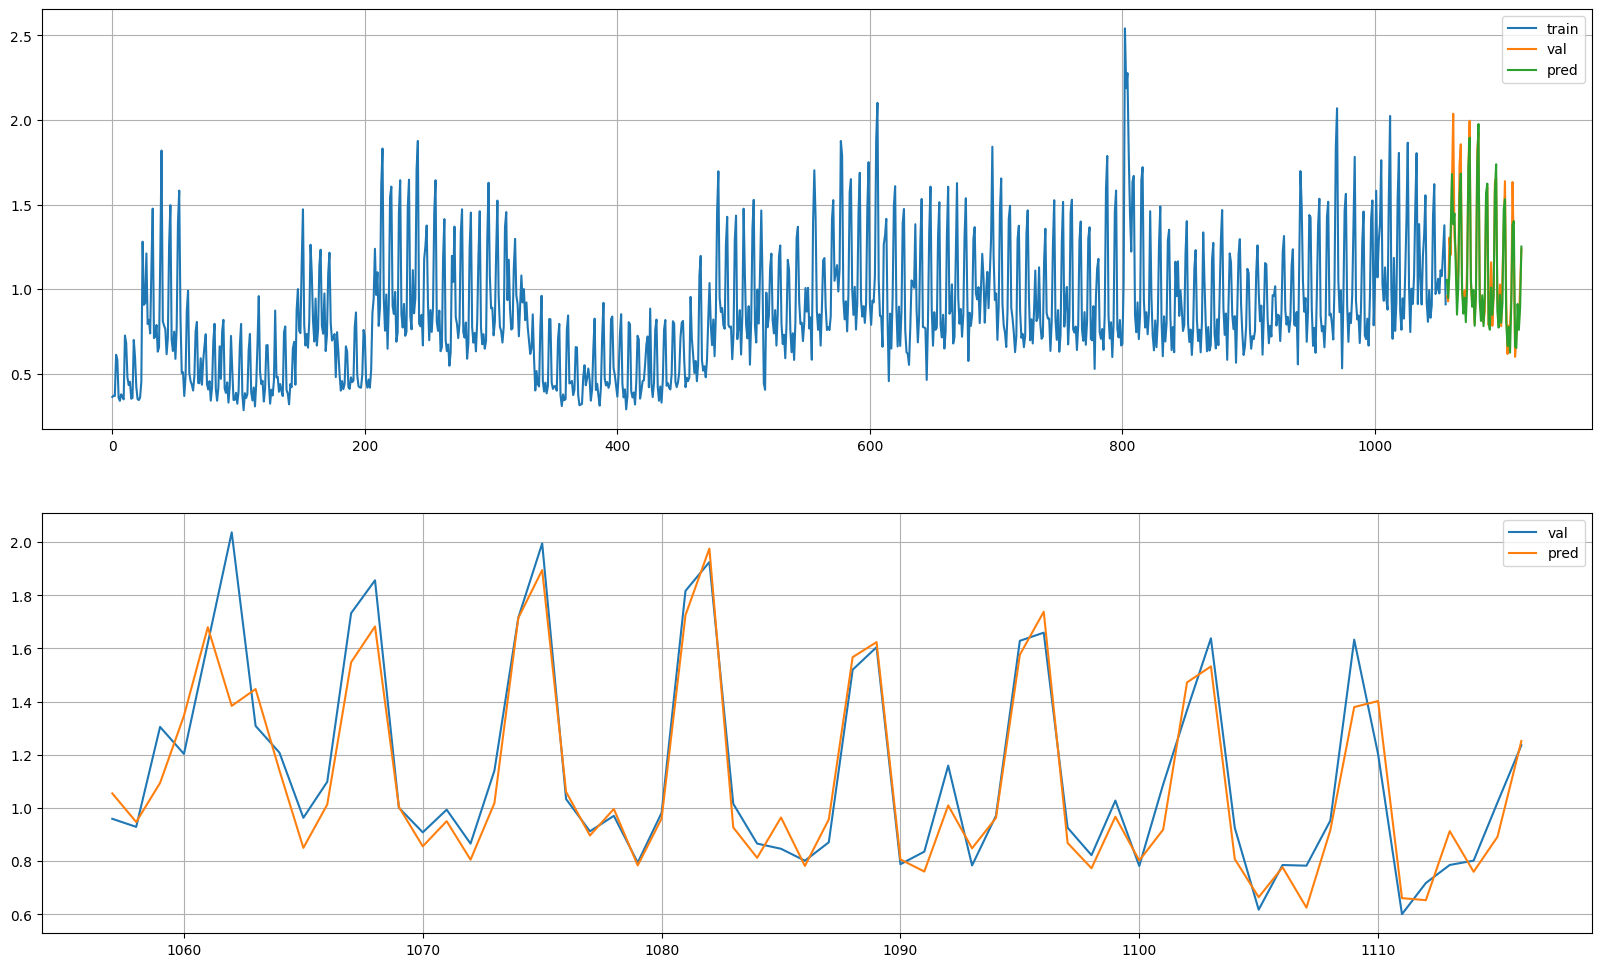

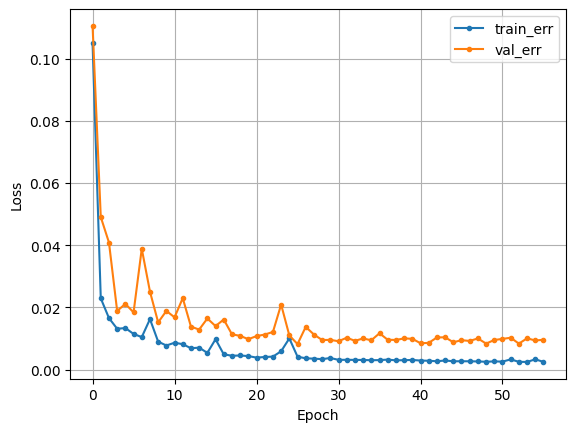

In [ ]:
from keras.layers import LSTM, GRU

input_shape = x_train.shape[1:]

model = Sequential()
model.add(Input(shape=input_shape))
model.add(LSTM(128, activation='tanh', return_sequences=True)) # 추가된 SimpleRNN 레이어
model.add(LSTM(128, activation='tanh', return_sequences=False)) # 추가된 SimpleRNN 레이어
model.add(Dense(1)) # input_shape는 feature의 개수
model.compile(loss='huber', optimizer=Adam(0.001))

es = EarlyStopping(patience=30, restore_best_weights=True)

# 모델 학습
history = model.fit(x_train, y_train, epochs=150, batch_size=32, validation_data=(x_val, y_val),
                    callbacks=[es])

# 모델 평가
pred = model.predict(x_val)
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, pred))}")
print(f"MAE: {mean_absolute_error(y_val, pred)}")
print(f"MAPE: {mean_absolute_percentage_error(y_val, pred)}")
print(f"R2 Score: {r2_score(y_val, pred)}")

# 결과 시각화
plot_model_result(y_train, y_val, pred)
dl_history_plot(history.history)

### GRU

Epoch 1/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1464 - val_loss: 0.0152
Epoch 2/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0105 - val_loss: 0.0140
Epoch 3/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0083 - val_loss: 0.0110
Epoch 4/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067 - val_loss: 0.0079
Epoch 5/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0137
Epoch 6/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0218
Epoch 7/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0189 - val_loss: 0.0098
Epoch 8/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - val_loss: 0.0071
Epoch 9/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0074
Epoch 10/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - val_loss: 0.0096
Epoch 11/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0103
Epoch 12/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 

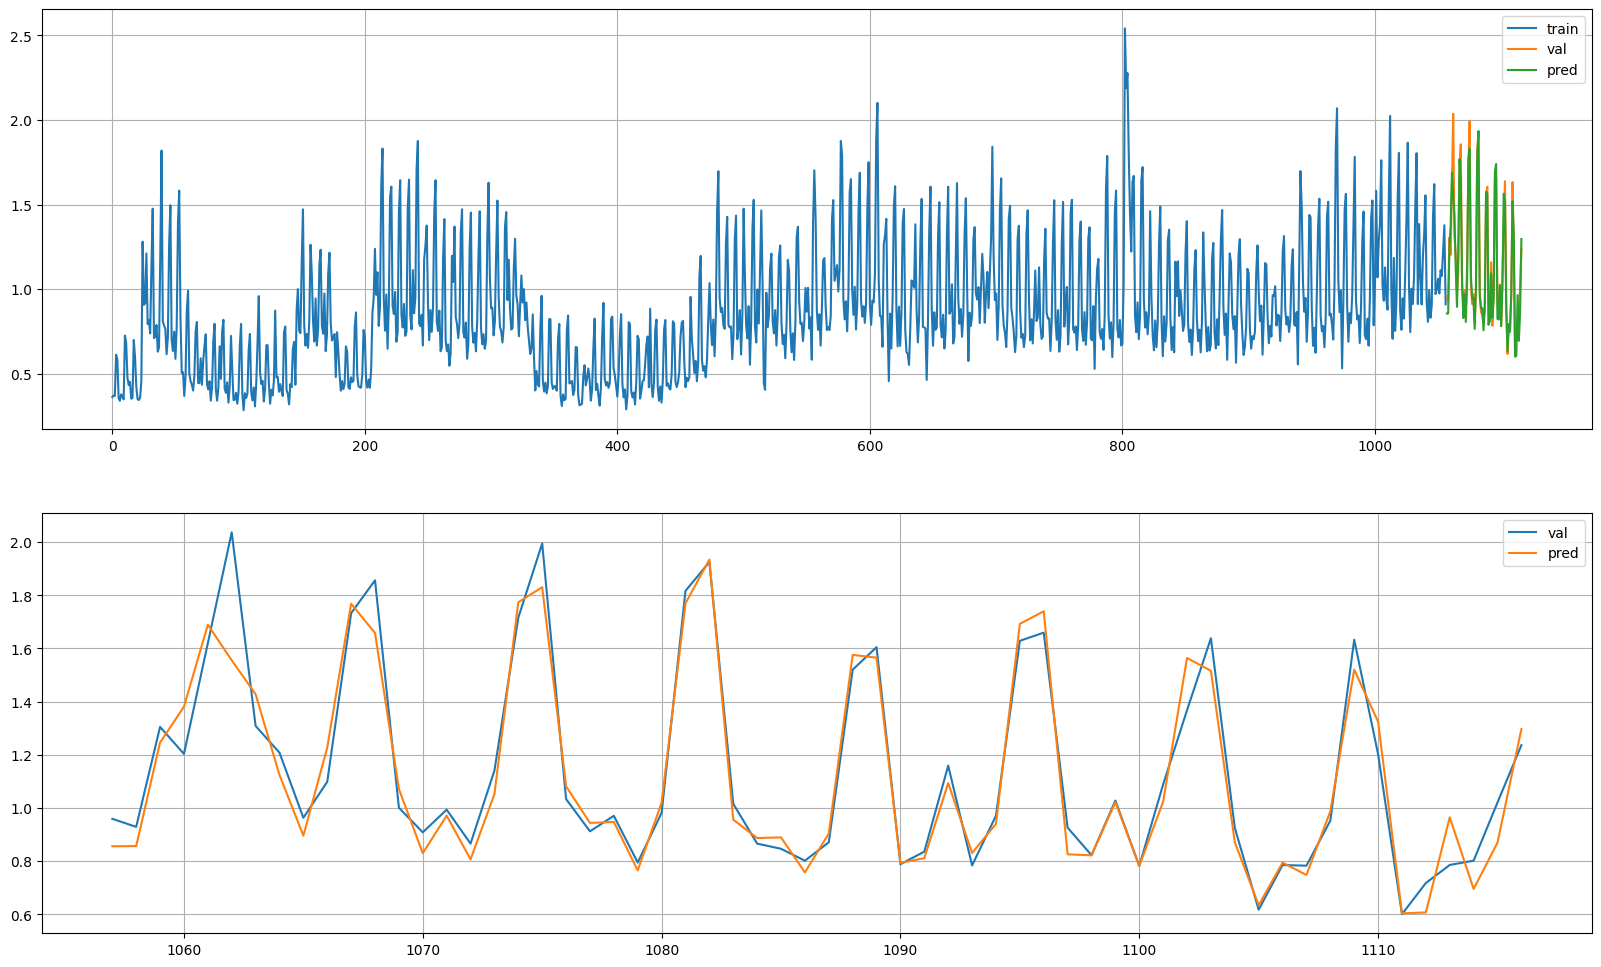

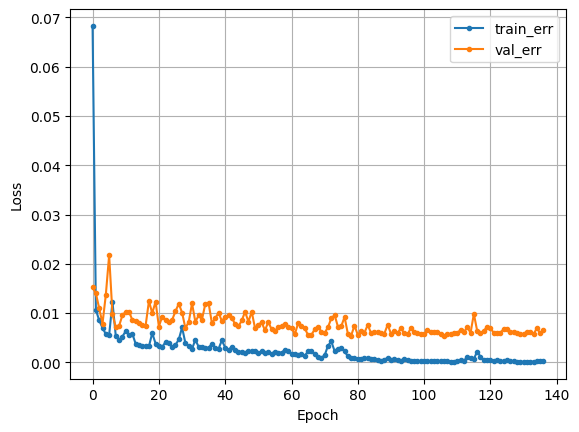

In [ ]:
from keras.layers import LSTM, GRU

input_shape = x_train.shape[1:]

model = Sequential()
model.add(Input(shape=input_shape))
model.add(GRU(128, activation='tanh', return_sequences=True)) # 추가된 GRU 레이어
model.add(GRU(128, activation='tanh', return_sequences=False)) # 추가된 GRU 레이어
model.add(Dense(1)) # input_shape는 feature의 개수
model.compile(loss='huber', optimizer=Adam(0.003))

es = EarlyStopping(patience=30, restore_best_weights=True)

# 모델 학습
history = model.fit(x_train, y_train, epochs=150, batch_size=32, validation_data=(x_val, y_val),
                    callbacks=[es])

# 모델 평가
pred = model.predict(x_val)
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, pred))}")
print(f"MAE: {mean_absolute_error(y_val, pred)}")
print(f"MAPE: {mean_absolute_percentage_error(y_val, pred)}")
print(f"R2 Score: {r2_score(y_val, pred)}")

# 결과 시각화
plot_model_result(y_train, y_val, pred)
dl_history_plot(history.history)

### 1DCNN

In [ ]:
from keras.layers import Conv1D, Flatten, BatchNormalization

(1057, 7, 24) (1057,)
Epoch 1/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.1722 - val_loss: 0.1354
Epoch 2/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0479 - val_loss: 0.0449
Epoch 3/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0253 - val_loss: 0.0300
Epoch 4/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0210 - val_loss: 0.0268
Epoch 5/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0169 - val_loss: 0.0264
Epoch 6/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0198 - val_loss: 0.0239
Epoch 7/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 - val_loss: 0.0226
Epoch 8/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0163 - val_loss: 0.0239
Epoch 9/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0174 - val_loss: 0.0215
Epoch 10/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0135 - val_loss: 0.0208
Epoch 11/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126 - val_loss: 0.0204
Epoch 12/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 

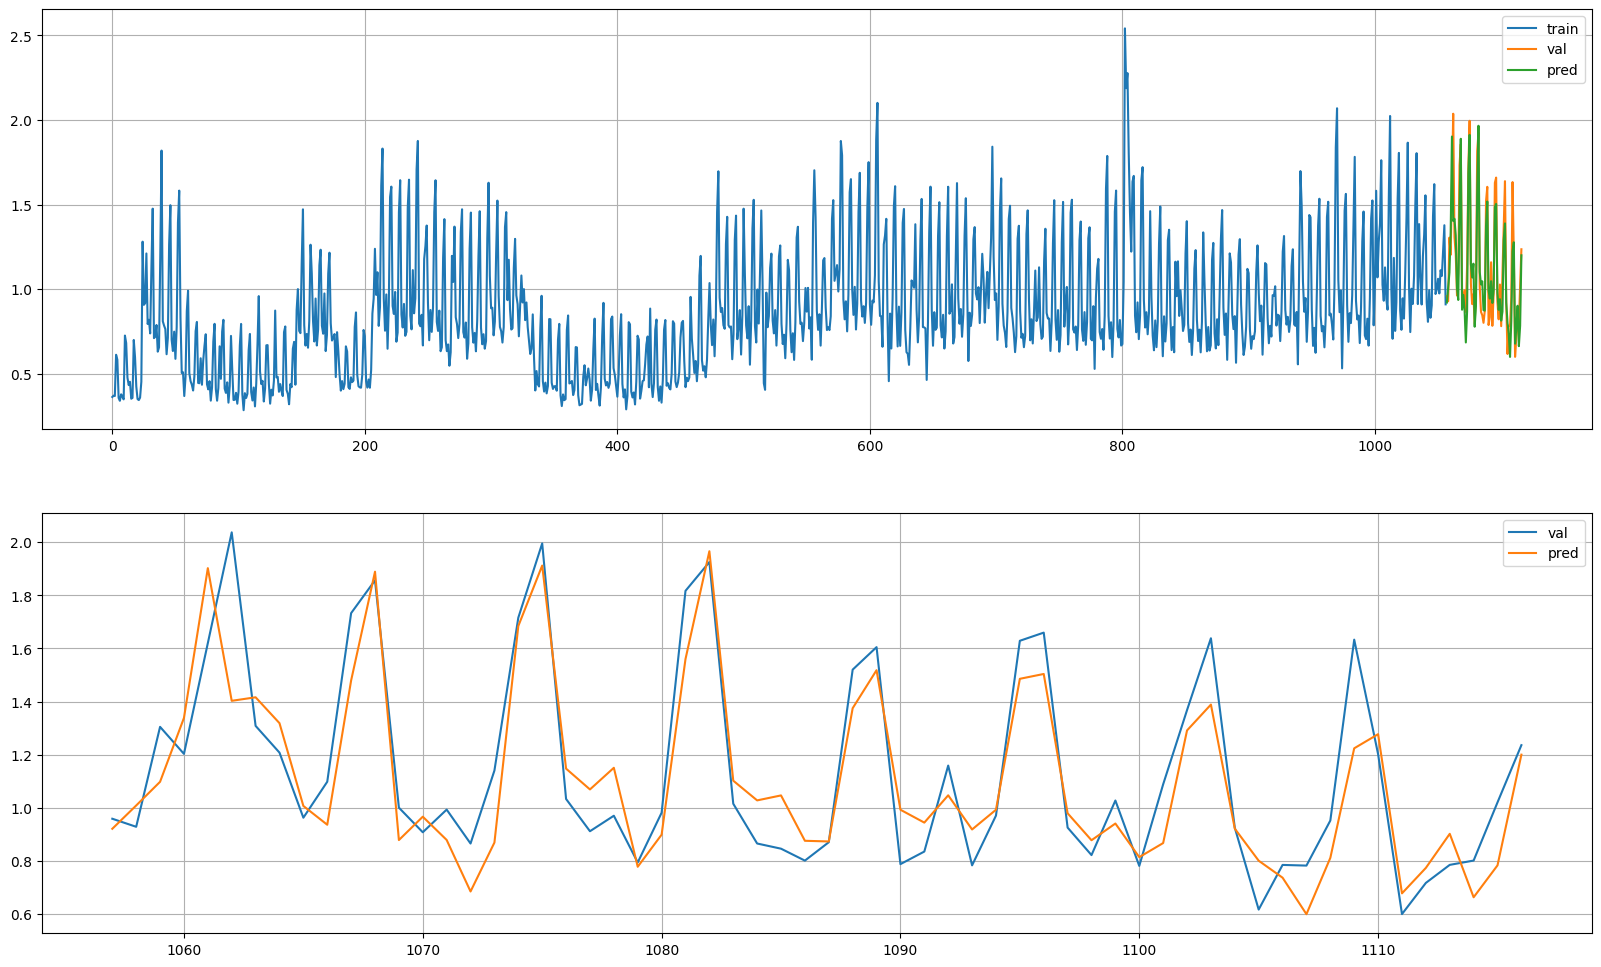

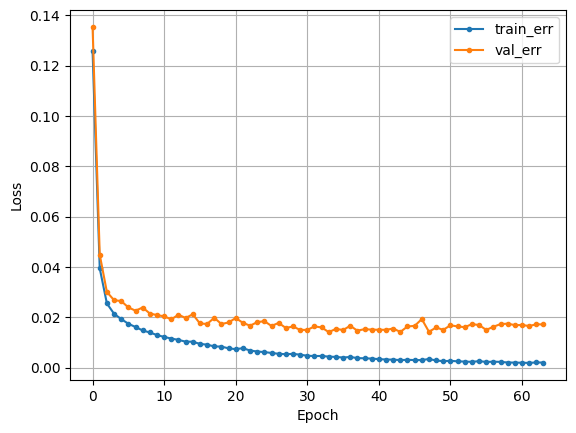

In [ ]:
x_train, x_val, y_train, y_val = x[:-60], x[-60:], y[:-60], y[-60:]
print(x_train.shape, y_train.shape)

input_shape = x_train.shape[1:]

model = Sequential()
model.add(Input(shape=input_shape))
model.add(Conv1D(128, 1, activation='relu')) # 추가된 CNN 레이어
model.add(Conv1D(64, 1, activation='relu')) # 추가된 CNN 레이어
model.add(Flatten())
model.add(Dense(1)) # input_shape는 feature의 개수
model.compile(loss='huber', optimizer=Adam(0.0002))

es = EarlyStopping(patience=30, restore_best_weights=True)

# 모델 학습
history = model.fit(x_train, y_train, epochs=150, batch_size=32, validation_data=(x_val, y_val),
                    callbacks=[es])

# 모델 평가
pred = model.predict(x_val)
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, pred))}")
print(f"MAE: {mean_absolute_error(y_val, pred)}")
print(f"MAPE: {mean_absolute_percentage_error(y_val, pred)}")
print(f"R2 Score: {r2_score(y_val, pred)}")

# 결과 시각화
plot_model_result(y_train, y_val, pred)
dl_history_plot(history.history)

## **(2) 상품 : 12 - Milk**

### **1) 데이터 준비**

In [ ]:
df = milk

df['target'] = df['Qty'].shift(-2)
dataset = df.dropna(axis=0)

train, valid = dataset[:-60], dataset[-60:]

x_train, x_val, y_train, y_val = train.drop(['target'], axis=1), valid.drop(['target'], axis=1), train['target'], valid['target']
print(x_train.shape, y_train.shape)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.fit_transform(x_val)

# 딥러닝 베이스라인 모델 생성
input_shape = x_train.shape[1:]

model = Sequential()
model.add(Input(shape=input_shape))
model.add(Dense(1)) # input_shape는 feature의 개수
model.compile(loss='mse', optimizer=Adam())

# 모델 학습
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val))

# 모델 평가
pred = model.predict(x_val)
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, pred))}")
print(f"MAE: {mean_absolute_error(y_val, pred)}")
print(f"MAPE: {mean_absolute_percentage_error(y_val, pred)}")
print(f"R2 Score: {r2_score(y_val, pred)}")

# 결과 시각화
plot_model_result(y_train, y_val, pred)
dl_history_plot(history.history)

(1057, 7, 24) (1057,)


(1057, 7, 24) (1057,)
Epoch 1/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.4462 - val_loss: 0.1941
Epoch 2/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0542 - val_loss: 0.0788
Epoch 3/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0545 - val_loss: 0.0737
Epoch 4/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0440 - val_loss: 0.0322
Epoch 5/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0241 - val_loss: 0.0241
Epoch 6/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0476 - val_loss: 0.0322
Epoch 7/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0205 - val_loss: 0.0230
Epoch 8/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0199 - val_loss: 0.0152
Epoch 9/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - val_loss: 0.0129
Epoch 10/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0183
Epoch 11/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0128 - val_loss: 0.0231
Epoch 12/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 

2024/11/15 02:37:22 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: Reading databricks credential configuration failed with MLflow tracking URI 'databricks', Please ensure that you installed 'databricks-sdk' library, set correct tracking URI and set up databricks authentication configuration correctly. The available tracking URI can be either 'databricks' (using 'DEFAULT' authentication profile) or 'databricks://{profile}'. To set up databricks authentication configuration, you can set environmental variables DATABRICKS_HOST + DATABRICKS_TOKEN, or set environmental variables DATABRICKS_HOST + DATABRICKS_CLIENT_ID + DATABRICKS_CLIENT_SECRET, or you can edit '~/.databrickscfg' file to set host + token or host + client_id + client_secret for specific profile section, or you can log in by command 'databricks auth login' which configures an authentication profile in '~/.databrickscfg' with auth_type of 'databricks-cli'.
For details of these aut

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
RMSE: 0.1025413633908829
MAE: 0.07852077162742613
MAPE: 0.06737347811623204
R2 Score: 0.8994350507071474


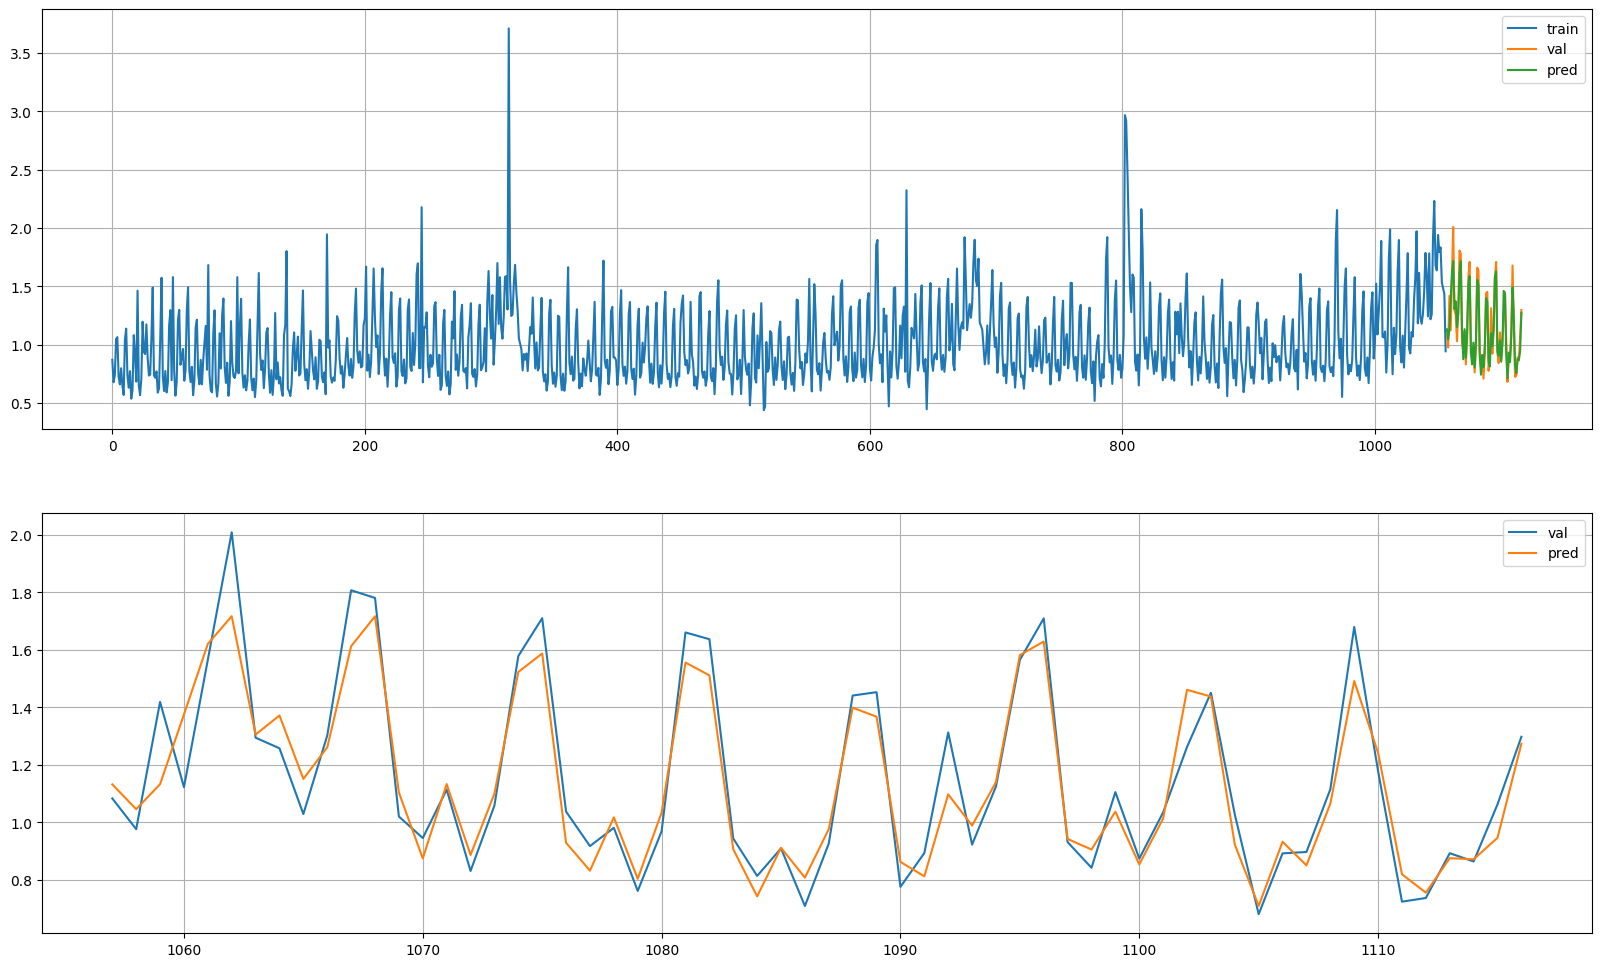

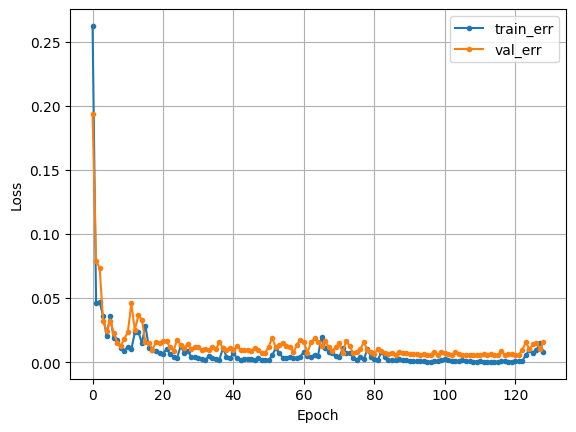

In [93]:
df = milk

df['target'] = df['Qty'].shift(-2)
dataset = df.dropna(axis=0)

x_ = dataset.drop(['target'], axis=1)
y_ = dataset['target'] / 10000

scaler = StandardScaler()
x_ = scaler.fit_transform(x_)

x, y = temporalize(pd.DataFrame(x_), y_, 7)

x_train, x_val, y_train, y_val = x[:-60], x[-60:], y[:-60], y[-60:]
print(x_train.shape, y_train.shape)

input_shape = x_train.shape[1:]

model = Sequential()
model.add(Input(shape=input_shape))
model.add(SimpleRNN(128, activation='tanh', return_sequences=True)) # 추가된 SimpleRNN 레이어
model.add(SimpleRNN(128, activation='tanh', return_sequences=False)) # 추가된 SimpleRNN 레이어
model.add(Dense(1)) # input_shape는 feature의 개수
model.compile(loss='huber', optimizer=Adam(0.003))

es = EarlyStopping(patience=30, restore_best_weights=True)
#lr =

# 모델 학습
history = model.fit(x_train, y_train, epochs=150, batch_size=32, validation_data=(x_val, y_val),
                    callbacks=[es])

# 모델 평가
pred = model.predict(x_val)
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, pred))}")
print(f"MAE: {mean_absolute_error(y_val, pred)}")
print(f"MAPE: {mean_absolute_percentage_error(y_val, pred)}")
print(f"R2 Score: {r2_score(y_val, pred)}")

# 결과 시각화
plot_model_result(y_train, y_val, pred)
dl_history_plot(history.history)

### **2) 모델링**

## **(3) 상품 : 42 - Agricultural products**

### **1) 데이터 준비**

In [ ]:
df = agri

df['target'] = df['Qty'].shift(-2)
dataset = df.dropna(axis=0)

train, valid = dataset[:-60], dataset[-60:]

x_train, x_val, y_train, y_val = train.drop(['target'], axis=1), valid.drop(['target'], axis=1), train['target'], valid['target']
print(x_train.shape, y_train.shape)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.fit_transform(x_val)

# 딥러닝 베이스라인 모델 생성
input_shape = x_train.shape[1:]

model = Sequential()
model.add(Input(shape=input_shape))
model.add(Dense(1)) # input_shape는 feature의 개수
model.compile(loss='mse', optimizer=Adam())

# 모델 학습
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val))

# 모델 평가
pred = model.predict(x_val)
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, pred))}")
print(f"MAE: {mean_absolute_error(y_val, pred)}")
print(f"MAPE: {mean_absolute_percentage_error(y_val, pred)}")
print(f"R2 Score: {r2_score(y_val, pred)}")

# 결과 시각화
plot_model_result(y_train, y_val, pred)
dl_history_plot(history.history)

(1057, 7, 24) (1057,)
Epoch 1/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.2928 - val_loss: 0.0098
Epoch 2/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0099
Epoch 3/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0081
Epoch 4/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0036
Epoch 5/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.6198e-04 - val_loss: 0.0039
Epoch 6/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6668e-04 - val_loss: 0.0047
Epoch 7/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3285e-04 - val_loss: 0.0037
Epoch 8/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6577e-04 - val_loss: 0.0022
Epoch 9/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9187e-04 - val_loss: 0.0037
Epoch 10/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9074e-04 - val_loss: 0.0040
Epoch 11/150
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6040e-04 - val_loss: 0.0072
Epoch 12/150

2024/11/15 02:39:42 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: Reading databricks credential configuration failed with MLflow tracking URI 'databricks', Please ensure that you installed 'databricks-sdk' library, set correct tracking URI and set up databricks authentication configuration correctly. The available tracking URI can be either 'databricks' (using 'DEFAULT' authentication profile) or 'databricks://{profile}'. To set up databricks authentication configuration, you can set environmental variables DATABRICKS_HOST + DATABRICKS_TOKEN, or set environmental variables DATABRICKS_HOST + DATABRICKS_CLIENT_ID + DATABRICKS_CLIENT_SECRET, or you can edit '~/.databrickscfg' file to set host + token or host + client_id + client_secret for specific profile section, or you can log in by command 'databricks auth login' which configures an authentication profile in '~/.databrickscfg' with auth_type of 'databricks-cli'.
For details of these aut

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step
RMSE: 0.0013952240770235312
MAE: 0.0011483104950686296
MAPE: 0.13368839501754629
R2 Score: 0.12192636418534519


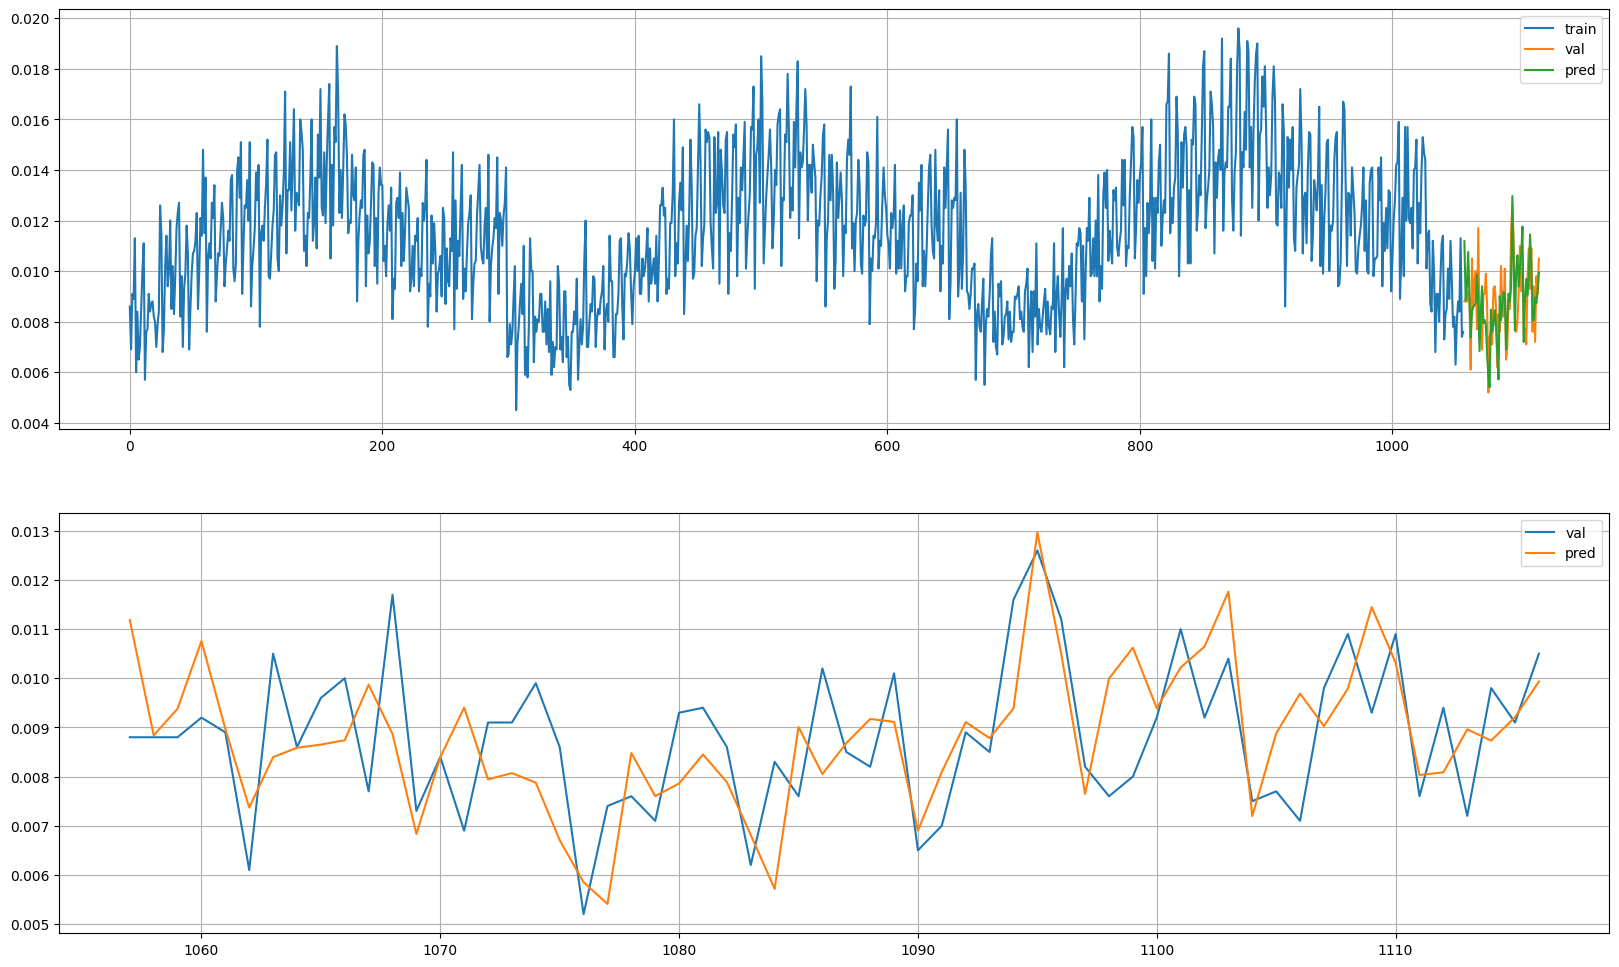

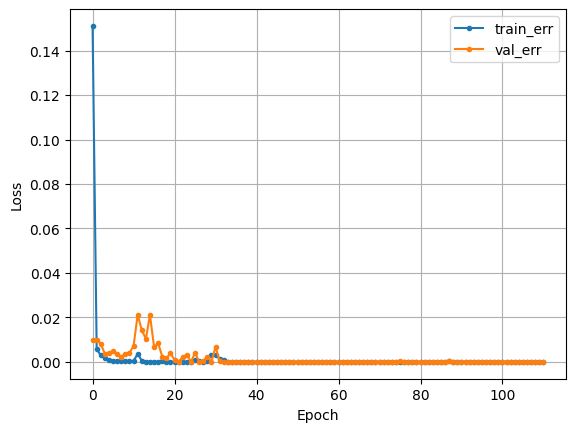

In [94]:
df = agri

df['target'] = df['Qty'].shift(-2)
dataset = df.dropna(axis=0)

x_ = dataset.drop(['target'], axis=1)
y_ = dataset['target'] / 10000

scaler = StandardScaler()
x_ = scaler.fit_transform(x_)

x, y = temporalize(pd.DataFrame(x_), y_, 7)

x_train, x_val, y_train, y_val = x[:-60], x[-60:], y[:-60], y[-60:]
print(x_train.shape, y_train.shape)

input_shape = x_train.shape[1:]

model = Sequential()
model.add(Input(shape=input_shape))
model.add(SimpleRNN(128, activation='tanh', return_sequences=True)) # 추가된 SimpleRNN 레이어
model.add(SimpleRNN(128, activation='tanh', return_sequences=False)) # 추가된 SimpleRNN 레이어
model.add(Dense(1)) # input_shape는 feature의 개수
model.compile(loss='huber', optimizer=Adam(0.003))

es = EarlyStopping(patience=30, restore_best_weights=True)

# 모델 학습
history = model.fit(x_train, y_train, epochs=150, batch_size=32, validation_data=(x_val, y_val),
                    callbacks=[es])

# 모델 평가
pred = model.predict(x_val)
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, pred))}")
print(f"MAE: {mean_absolute_error(y_val, pred)}")
print(f"MAPE: {mean_absolute_percentage_error(y_val, pred)}")
print(f"R2 Score: {r2_score(y_val, pred)}")

# 결과 시각화
plot_model_result(y_train, y_val, pred)
dl_history_plot(history.history)

### **2) 모델링**

# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

In [ ]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

## **(1) LSTM 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

* **모델링**

### **2) 상품 : 12 - Milk**

* **데이터 준비**

* **모델링**

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

## **(2) CNN 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

* **모델링**

### **2) 상품 : 12 - Milk**

* **데이터 준비**

* **모델링**

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

# **5.데이터 저장**

* **세부 요구사항**
    * 상품코드별 데이터셋을 저장하시오.
    * joblib.dump를 이용하시오.
    * 저장할 파일의 확장자는 보통 .pkl 입니다.